<a href="https://colab.research.google.com/github/marc1971/Hello-World/blob/master/train_using_pretrained_model_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook to train a pretrained model (ViT) for image classification**

In [ ]:
#Import needed packages
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

#Import own functions
import helper_functions
import engine

In [ ]:
# Connecting to Google Drive to get access to data, that is used for training the model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting divice
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['alpin','jura', 'mittelland', 'voralpin']

# 5. Set random seeds
from helper_functions import set_seeds
set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 143MB/s]


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo
summary(model=pretrained_vit,
        input_size=(64, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
VisionTransformer (VisionTransformer)                        [64, 3, 224, 224]  [64, 4]            768                Partial
├─Conv2d (conv_proj)                                         [64, 3, 224, 224]  [64, 768, 14, 14]  (590,592)          False
├─Encoder (encoder)                                          [64, 197, 768]     [64, 197, 768]     151,296            False
│    └─Dropout (dropout)                                     [64, 197, 768]     [64, 197, 768]     --                 --
│    └─Sequential (layers)                                   [64, 197, 768]     [64, 197, 768]     --                 False
│    │    └─EncoderBlock (encoder_layer_0)                   [64, 197, 768]     [64, 197, 768]     (7,087,872)        False
│    │    └─EncoderBlock (encoder_layer_1)                   [64, 197, 768]     [64, 197, 768]     (7,087,872)        False
│    

#### Notice: only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [ ]:
# Setup directory paths to train and test images
train_dir = '/content/drive/My Drive/ColabNotebooks/Data/images_transformer/train'
test_dir = '/content/drive/My Drive/ColabNotebooks/Data/images_transformer/test'

It's important to ensure the own custom data is transformed/formatted in the same way the data the original model was trained on!

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### Now transforms is ready, we can turn the images into DataLoaders using the create_dataloaders()

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
    ):

  # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
    class_names = train_data.classes

  # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=64) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from engine import train

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8101 | train_acc: 0.6734 | test_loss: 0.5633 | test_acc: 0.7969
Epoch: 2 | train_loss: 0.4947 | train_acc: 0.8319 | test_loss: 0.4596 | test_acc: 0.8474
Epoch: 3 | train_loss: 0.4118 | train_acc: 0.8645 | test_loss: 0.4097 | test_acc: 0.8558
Epoch: 4 | train_loss: 0.3615 | train_acc: 0.8856 | test_loss: 0.3764 | test_acc: 0.8770
Epoch: 5 | train_loss: 0.3244 | train_acc: 0.8990 | test_loss: 0.3567 | test_acc: 0.8702
Epoch: 6 | train_loss: 0.3009 | train_acc: 0.9059 | test_loss: 0.3373 | test_acc: 0.8786
Epoch: 7 | train_loss: 0.2795 | train_acc: 0.9158 | test_loss: 0.3186 | test_acc: 0.8942
Epoch: 8 | train_loss: 0.2617 | train_acc: 0.9206 | test_loss: 0.3106 | test_acc: 0.8978
Epoch: 9 | train_loss: 0.2466 | train_acc: 0.9286 | test_loss: 0.3018 | test_acc: 0.9014
Epoch: 10 | train_loss: 0.2346 | train_acc: 0.9281 | test_loss: 0.2942 | test_acc: 0.8998
Epoch: 11 | train_loss: 0.2236 | train_acc: 0.9341 | test_loss: 0.2862 | test_acc: 0.8966
Epoch: 12 | train_l

Visualizing the training-process:


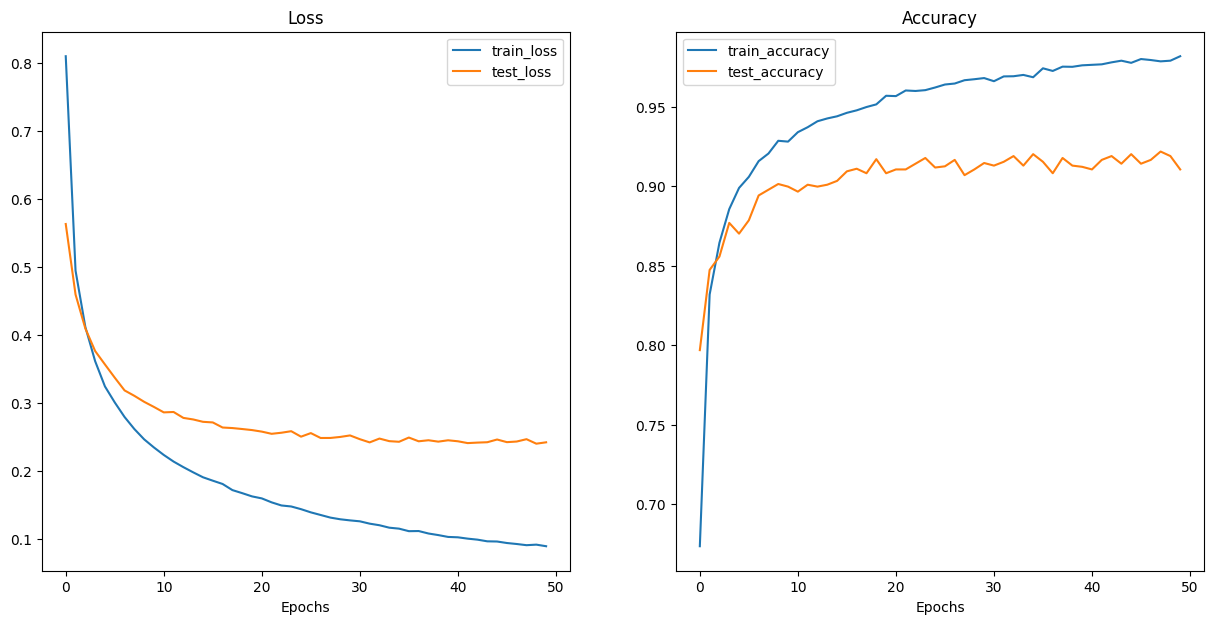

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

# Making Predictions:

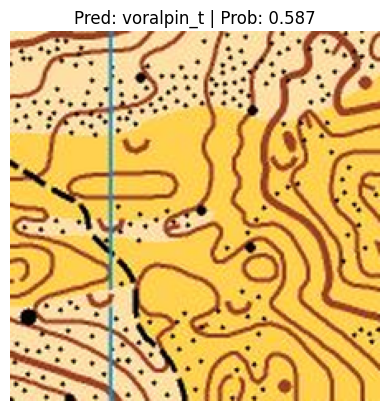

In [ ]:
import requests

# Import function to make predictions on images and plot them
from helper_functions import pred_and_plot_image
# Setup custom image path
#Test-Maps:
#AR01_0-1.png -> alpin (Arosa)
#BR01.png -> jura (Brunnersberg)
#CB01_0-0.png -> jura (Chanet de Bevais)
#HB01_0-0.png -> mittelland (Harben)
#LH01_0-1.png -> mittelland (Längholz)
#MU02_0-1.png -> mittelland (Minuberghöchi)

#Example
custom_image_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/unseen/AR01_0-1.png"


# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

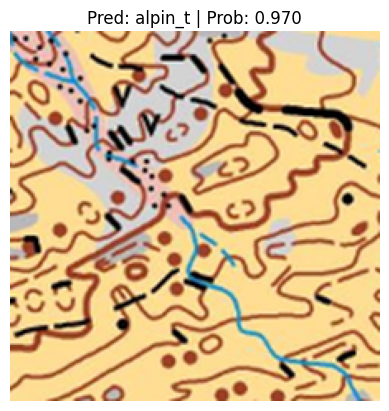

In [ ]:
# Applying the predictions to 130 unseen Images

# Import function to make predictions on images and plot them
from helper_functions import pred_and_plot_image
import os



# Setup custom image path
image_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/unseen/"
image_save_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/pred/"
for img in os.listdir(image_path):
  pred_and_plot_image(model=pretrained_vit,
                    image_path=image_path+img,
                    class_names=class_names)
  plt.savefig(image_save_path+img, dpi=300, bbox_inches='tight')

Now we get the results off applying the model and write it into a Pandas DataFrame

In [ ]:
from typing import List
import torchvision


def pred_and_plot_image2(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
	):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """
# 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)


    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8  crating lists with results
    id_lst.append(img[0:2])
    prob_lst.append(target_image_pred_probs)
    prd_lst.append(target_image_pred_label)

    # 8. Plot the image alongside the prediction and prediction probability
    #plt.imshow(
        #target_image.squeeze().permute(1, 2, 0)
    #)  # make sure it's the right size for matplotlib
    #if class_names:
        #title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    #else:
        #title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    #plt.title(title)
    #plt.axis(False)

In [ ]:

# Creating a
image_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/unseen/"
image_save_path = "/content/drive/My Drive/ColabNotebooks/Data/images_transformer/pred/"
id_lst = []
prd_lst =[]
prob_lst = []

for img in os.listdir(image_path):
  pred_and_plot_image2(model=pretrained_vit,
                    image_path=image_path+img,
                    class_names=class_names)
  #plt.savefig(image_save_path+img, dpi=300, bbox_inches='tight')

In [ ]:

prd_lst_np = []
prob_lst_np = []
import torch

# Assuming 'your_tensor' is a CUDA tensor
for item in prd_lst:
  your_tensor = item.cuda()
  numpy_array = your_tensor.cpu().numpy()
  value = numpy_array[0]
  prd_lst_np.append(value)


for item in prob_lst:
  your_tensor = item.cuda()
  numpy_array = your_tensor.cpu().numpy()
  value = numpy_array[0].max()
  prob_lst_np.append(value)
# Move the tensor to the CPU and then convert to NumPy
#numpy_array = your_tensor.cpu().numpy()

print(len(prd_lst_np))
print(len(prob_lst_np))

131
131


In [ ]:
import pandas as pd

# list of name, degree, score


# dictionary of lists
dict = {'Karte': id_lst, 'Typ': prd_lst_np, 'Probability': prob_lst_np}

df = pd.DataFrame(dict)

# Export the DataFrame to an Excel file
df.to_excel('/content/drive/My Drive/ColabNotebooks/Data/images_transformer/Testresults.xlsx', index=False)
df


,Karte,Typ,Probability
0,BR,3,0.579545
1,BR,2,0.965825
2,AR,3,0.783785
3,BR,2,0.836831
4,BR,1,0.738026
...,...,...,...
126,MU,2,0.702439
127,MU,2,0.979232
128,MU,2,0.939475
129,MU,2,0.974056
